In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
from scipy.integrate import solve_ivp

## Neural activity model in V1

$$\frac{\partial a(\mathbf{r}, \phi, t)}{\partial t} = - \alpha \cdot a(\mathbf{r}, \phi, t) + \frac{\mu}{\pi} \int_0^\pi w_\text{LOC}(\phi - \phi') \cdot \sigma\left[a(\mathbf{r}, \phi', t)\right] d\phi'
+ \nu \int_{-\infty}^\infty w_\text{LAT}(s) \cdot \sigma\left[a(\mathbf{r} + s \mathbf{e}_\phi, \phi, t)\right] ds
$$

$$\nu = \mu \beta$$

$$w_\text{LOC}(\phi) = \frac{1}{\sigma_1}\exp\left(\frac{-\phi^2}{2 \sigma_1^2}\right) - \frac{1}{\sigma_2} \exp\left(\frac{-\phi^2}{2 \sigma_2^2}\right)$$

$$w_\text{LAT}(s) = \frac{1}{\sigma_3}\exp\left(\frac{-s^2}{2 \sigma_3^2}\right) - \frac{1}{\sigma_4} \exp\left(\frac{-s^2}{2 \sigma_4^2}\right)$$

Bressloff PC, Cowan JD, Golubitsky M, Thomas PJ, Wiener MC. What geometric visual hallucinations tell us about the visual cortex. Neural Comput. 2002;14(3):473-491. doi:10.1162/089976602317250861

## Discretization
$$x, y \in [0, 1), \ \phi \in [0, \pi)$$
$$a(\mathbf{r}, \phi, t) \rightarrow a_{nml}(t), \ n, m \in \{0, 1, \ldots, N - 1\}, \ l \in \{0, 1, \ldots, M - 1\}$$

$$x_m = \frac{m + 1 / 2}{N} $$
$$y_n = \frac{n + 1 / 2}{N}$$
$$\phi_l = \frac{\pi \cdot l}{M}$$

$$\frac{\mathrm{d} a_{nml} (t)}{\mathrm{d} t} = -\alpha a_{nml} (t) + \sum_{i,j=0}^{N-1} \sum_{l = 0}^{M - 1} U_{nml,ijk} \cdot \sigma\left[a_{ijk} (t)\right]$$

In [108]:
def weight_func(x, sigma1, sigma2):
    return np.exp(-x**2 / 2 / sigma1**2) / sigma1 - np.exp(-x**2 / 2 / sigma2**2) / sigma2

def sigmoid(x, slope = 0.5):
    smaller = x < -2 / slope
    larger = x > 2 / slope
    out = np.zeros(x.shape)
    out[smaller] = 0
    out[larger] = 1
    inside = ~smaller & ~larger
    out[inside] = 1 / (1 + np.exp(-4 * slope * x[inside]))
    return out

def angle_dist(angle1, angle2):
    return np.pi / 2 - np.abs(np.pi / 2 - np.abs(angle1 - angle2) % np.pi)

def get_lateral_sigmas(r0, maxiter = 100, eps = 1e-7):
    sigma2 = r0
    for _ in range(maxiter):
        diff = r0 - np.sqrt((2 * sigma2 * np.log(sigma2 + 1)) / (sigma2 + 2))
        if abs(diff) < eps:
            return sigma2 / (1 + sigma2), sigma2
        sigma2 = sigma2 + diff
    raise ValueError("Reached maximum iteration count!")
    
def periodic_coords(coords, origin, L):
    diffs = coords - origin
    smaller_than_half = diffs < -L / 2
    larger_than_half = diffs >= L / 2
    diffs[smaller_than_half] += L
    diffs[larger_than_half] -= L
    return diffs + origin

class V1System:
    
    def _build_matrix(self):
        step_size = self._L / self._N
        cell_area = step_size**2
        delta_phi = np.pi / self._M
        
        kernel_half_width = int(self._cutoff_radius / step_size)
        index_range = np.arange(-kernel_half_width, kernel_half_width + 1)
        x = step_size * index_range
        xx, yy = np.meshgrid(x, x)
        dist = np.sqrt(xx**2 + yy**2)
        inside =  (dist <= self._cutoff_radius) & (dist > step_size / 2)
        kernel_index_grid = np.array([[(n, m) for m in index_range] for n in index_range], dtype = int)[inside]
        kernel_lateral_weights = weight_func(dist[inside],self._sigma1, self._sigma2) / dist[inside]
        kernel_angles = np.arctan2(yy[inside], xx[inside]) % (2 * np.pi)
        kernel_sector_indices = (((kernel_angles + delta_phi / 2) % np.pi) / delta_phi).astype(int)
        
        coo_rows = []
        coo_cols = []
        coo_data = []
        to_index = lambda n, m, k: self._M * self._N * n + self._M * m + k
        #(n, m, k) --> MN * n + M * m + k
        for n in range(self._N):
            for m in range(self._N):
                for k in range(self._M):
                    idx = to_index(n, m, k)
                    #local interaction
                    for l in range(k + 1, self._M):
                        weight = self._angle_weights[k, l]
                        col = to_index(n, m, l)
                        coo_rows.append(idx)
                        coo_cols.append(col)
                        coo_data.append(self._mu  / self._M * weight)
                        #transposed
                        coo_rows.append(col)
                        coo_cols.append(idx)
                        coo_data.append(self._mu  / self._M * weight)
        #lateral interaction
        for n in range(self._N):
            for m in range(self._N):
                for rel_pos, weight, sector_index in zip(kernel_index_grid, kernel_lateral_weights, kernel_sector_indices):
                    i = (n + rel_pos[0]) % self._N
                    j = (m + rel_pos[1]) % self._N
                    row = to_index(n, m, sector_index)
                    col = to_index(i, j, sector_index)
                    data = weight * cell_area * self._mu * self._beta / delta_phi
                    coo_rows.append(row)
                    coo_cols.append(col)
                    coo_data.append(data)
                
        total_dim = self._M * self._N**2
        self._evolution_matrix = scipy.sparse.coo_array((coo_data, (coo_rows, coo_cols)), shape = (total_dim, total_dim))
        self._evolution_matrix = scipy.sparse.csr_array(self._evolution_matrix)
    
    def __init__(self, alpha = 1, beta = 0.5, mu = 1, r0 = None, N = 50, M = 4):
        self._L = 1 # in units of N * 0.7 mm
        if r0 is None:
            r0 = 3.2 / 50
        self._alpha = alpha
        self._beta = beta
        sigma1, sigma2 = get_lateral_sigmas(r0)
        self._sigma1 = sigma1
        self._sigma2 = sigma2
        self._sigma3 = 0.6060482974023431
        self._sigma4 = 1.538382226567759
        self._cutoff_radius = 3.5 * sigma2
        self._mu = mu
        self._N = N
        self._M = M
        self._angles = np.pi * np.arange(M) / M
        self._angle_weights = weight_func(angle_dist(0, np.subtract.outer(self._angles, self._angles)), self._sigma3, self._sigma4)
        self._build_matrix()
    
    def integrate(self, *args, **kwargs):
        dadt = lambda t, a : -self._alpha * a + self._evolution_matrix @ sigmoid(a)
        return solve_ivp(dadt, *args, **kwargs)

In [270]:
test_system = V1System(alpha = 1, beta = 3, mu = 17, N = 140, M = 20)

In [271]:
total_dim = test_system._N**2 * test_system._M
a0 = np.random.uniform(-1e-12, 1e-12, total_dim)
T = 60
t_eval = np.linspace(0, T, 10)
sol = test_system.integrate((0, T), a0, t_eval = t_eval, rtol = 1e-10)


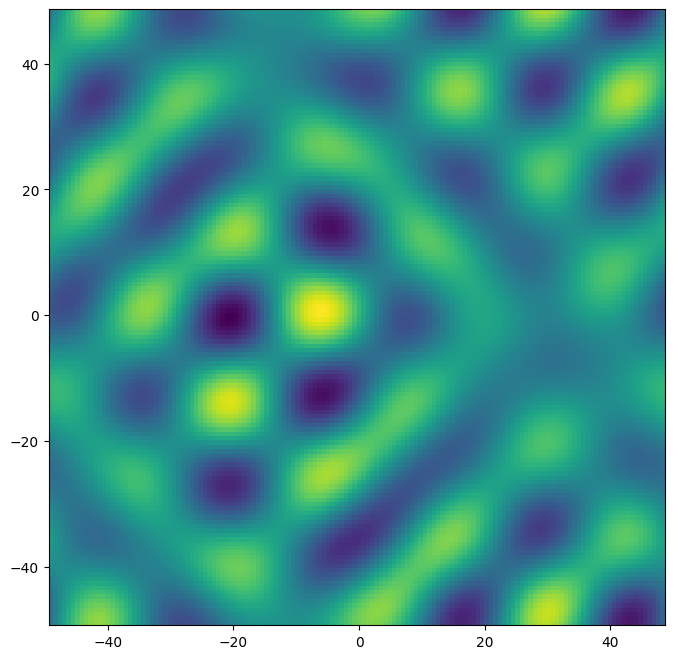

In [307]:
x = 0.7 * np.arange(test_system._N) - test_system._N * 0.7 / 2 # mm
xx, yy = np.meshgrid(x, x) #grid coords in mm

fig, ax = plt.subplots(1, 1, figsize = (16, 8))
ax.set_aspect(1)
snap = sol.y[:, -1].reshape(test_system._N, test_system._N, test_system._M)
#ax[0].pcolormesh(xx, yy, snap[:, :, 3])
ax.pcolormesh(xx, yy, np.mean(snap, axis = 2))

## Retino-Cortical Map

$$x = \frac{\alpha}{\epsilon} \ln\left[\frac{\epsilon}{w_0} r_R\right], \quad y = \frac{\beta \theta_R}{\epsilon}$$

$$r_R = \frac{w_0}{\epsilon}\exp\left[\frac{\epsilon x}{\alpha}\right] ,\quad \theta_R = \frac{\epsilon y}{\beta}$$

$\epsilon = 0.051, \quad w_0 = 0.087, \quad \alpha = \frac{2070}{\pi} \frac{\mathrm{mm}}{\mathrm{rad}}, \quad \beta = \frac{1035}{\pi} \frac{\mathrm{mm}}{\mathrm{rad}}$

In [336]:
periodic_padded_data = np.mean(snap, axis = 2)
periodic_padded_data = np.vstack((periodic_padded_data, periodic_padded_data[0]))
periodic_padded_data = np.hstack((periodic_padded_data, periodic_padded_data[:, 0].reshape(141, 1)))
x_padded =  0.7 * np.arange(test_system._N + 1) - test_system._N * 0.7 / 2
xx_padded, yy_padded = np.meshgrid(x_padded, x_padded)

In [337]:
xx_padded.shape

(141, 141)

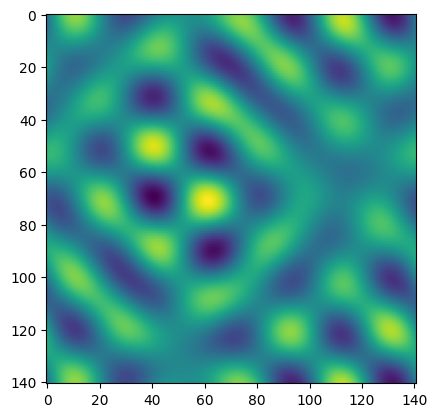

In [335]:
plt.imshow(periodic_padded_data)

In [349]:
def inverse_retino_cortical_map(x, y, eps = 0.051, w0 = 0.087, alpha = 3/np.pi, beta = 1.589 / 2):
    r_R = w0 / eps * np.exp(eps * x / alpha)
    theta_R = eps * y / beta
    return r_R, theta_R

In [350]:
r, theta = inverse_retino_cortical_map(xx_padded, yy_padded)

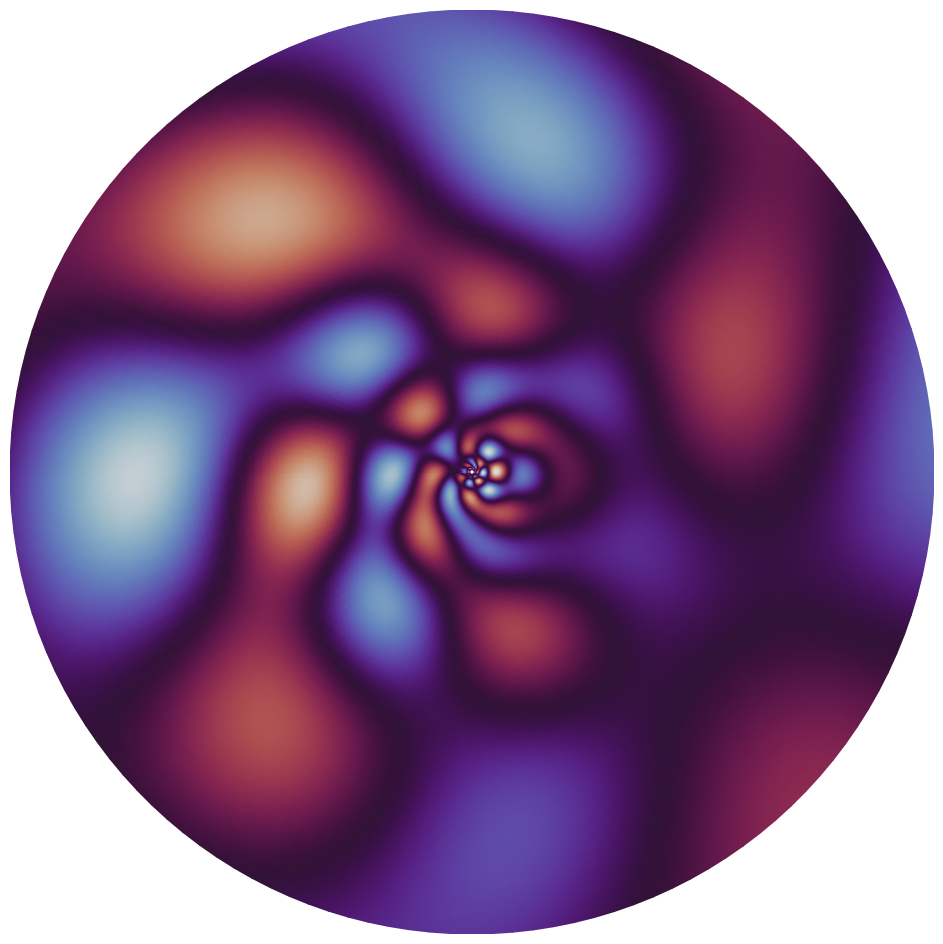

In [356]:
xx_new = r * np.cos(theta)
yy_new = r * np.sin(theta)
fig, ax = plt.subplots(1, 1, figsize = (12, 12))
ax.set_aspect(1)
plt.pcolormesh(xx_new, yy_new, periodic_padded_data, shading = "gouraud", cmap = "twilight")
ax.set_axis_off()

In [359]:
fig.savefig("v1-hallucination.png", bbox_inches = "tight", dpi = 300)